<a href="https://colab.research.google.com/github/chris051091/Seminario-3/blob/master/maps/src/Mapa_Temperatura_20h_7h_mas_even.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall shapely -y
!pip install shapely --no-binary shapely
!pip install cartopy
# !pip install git+https://github.com/SciTools/cartopy.git --no-binary cartopy
!pip install netCDF4 

Found existing installation: Shapely 1.8.4
Uninstalling Shapely-1.8.4:
  Successfully uninstalled Shapely-1.8.4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 199 kB 6.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for shapely: filename=Shapely-1.8.4-cp37-cp37m-linux_x86_64.whl size=669465 sha256=65cb1f100436b2f8ee70c173fadf2d7feefe274b069a27f90c819c2ae59554f5
  Stored in directory: /root/.cache/pip/wheels/0b/f0/55/139a0ab07fbf91378f9b7062842aee4d4bb3566a1fc30ac7a4
Successfully built shapely
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.8 MB 7.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |█████████████

# **Importar Bibliotecas**

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import io
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.colors import LinearSegmentedColormap
from urllib.request import urlopen, Request
from PIL import Image
from netCDF4 import Dataset
import cartopy.feature as cfeature
from scipy.ndimage.filters import gaussian_filter

from google.colab import drive
drive.mount('/content/drive')

%matplotlib inline

Mounted at /content/drive


In [3]:
!mkdir -p drive/MyDrive/Seminario-3-master/figure

In [4]:
#***********************************
# Una escala de colores especial (opcional):
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
   import matplotlib.colors as colors
   new_cmap = colors.LinearSegmentedColormap.from_list(
       'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
       cmap(np.linspace(minval, maxval, n)))
   return new_cmap


def registerColorMap(count, typeCmap = 'gray', nameNewCmap = ''):
    # ncolors = int(count.max())
    ncolors = 85
    color_array = plt.get_cmap(typeCmap)(range(ncolors))
    
    # Cambia transparencia de los colores (alpha) considerando el mayor número de repeticiones
    color_array[:,-1] = np.linspace(0.0,1.0,ncolors)

    # Crea el ColorMap Object
    nameNewCmap = typeCmap + '_' if nameNewCmap == '' else nameNewCmap
    
    return LinearSegmentedColormap.from_list(name=nameNewCmap, colors=color_array), nameNewCmap



# **Configuración de directorios y nombres de los archivos**


In [5]:
PATH_DRIVE = 'drive/MyDrive/Seminario-3-master'
PATH_DADOS = '/dados/'
PATH_FIGURE = '/figure/'
FILE_DATOS_ESTACION = 'events_MM_nxny1426.csv'
FILE_RELIEVE = 'GMRTv3_8_20210316topo_LR.grd'

In [6]:
df = pd.read_csv(PATH_DRIVE + PATH_DADOS + FILE_DATOS_ESTACION, 
                 sep = ';'
                )

In [7]:
#***********************************
# Estima el histograma 2D de los campos  
count, x_coord, y_coord = np.histogram2d(np.array(df['lon_t'], dtype=float),
                                          np.array(df['lat_t'], dtype=float), bins = [14, 26], range= [[-75.05,-73.05],[4.84,8.56]])

area = 15.93*15.91
count = count/(area*7) #Poner en densidad == eventos/ km cuadrados * años



# **Configuración del mapa**

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naci

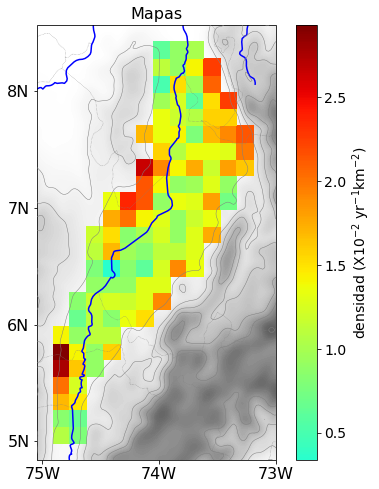

In [8]:
#***********************************
# Configura el mapa
fig = plt.figure(figsize=(7,8))
ax1 = plt.axes(projection=ccrs.Mercator(central_longitude=-75))
ax1.set_title('Mapas',fontsize=16)
extent = [-75.05, -73.05, 4.84, 8.56]
ax1.set_extent(extent)
ax1.set_xticks(np.arange(-75,-72),crs=ccrs.PlateCarree()) # Configura los indicadores de longitud
ax1.set_yticks(np.arange(5,9),crs=ccrs.PlateCarree()) # Configura los indicadores de latitud
lon_formatter = LongitudeFormatter(number_format='.0f',degree_symbol='',dateline_direction_label=True) # Formata longitud
lat_formatter = LatitudeFormatter(number_format='.0f',degree_symbol='') # Formata Latitud  
ax1.xaxis.set_major_formatter(lon_formatter) # Configura Longitud
ax1.yaxis.set_major_formatter(lat_formatter) # Configura Latitud
ax1.tick_params(labelsize=16)

#***********************************
# Ríos, fronteras, etc:

rios = cfeature.NaturalEarthFeature(
       category='physical',
       name='rivers_lake_centerlines',
       scale='10m',
       facecolor='none' )
limites_dep = cfeature.NaturalEarthFeature(
   category='cultural',
   name='admin_1_states_provinces_lines',
   scale='10m',
   facecolor='none')
limites_int = cfeature.NaturalEarthFeature(
   category='cultural',
   name='admin_0_countries',
   scale='10m',
   facecolor='none')
ax1.add_feature(limites_int, edgecolor='0.5',linewidth=0.5, linestyle=':') #estos dos son opcionales
ax1.add_feature(limites_dep, edgecolor='0.5',linewidth=0.5, linestyle=':')
ax1.add_feature(rios, edgecolor='blue', linewidth=1.5 ) # los ríos son importantes

#***********************************
#datos de altura:

var2 = Dataset(PATH_DRIVE + PATH_DADOS + FILE_RELIEVE, mode='r')
xtopo=np.arange(var2.variables['x_range'][0],var2.variables['x_range'][1]+0.5*var2.variables['spacing'][0],var2.variables['spacing'][0])
ytopo=np.arange(var2.variables['y_range'][0],var2.variables['y_range'][1]+0.5*var2.variables['spacing'][1],var2.variables['spacing'][1])
z=var2.variables['z'][:]
var2.close()
xt0,yt0=np.meshgrid(xtopo,ytopo)
z=np.reshape(z,xt0.shape)[::-1,:]
# suavizar los datos de altura:
z=gaussian_filter(z,2)
# niveles de elevación en escala de grises
plt.contourf(xt0,yt0,z, cmap='Greys', levels=np.arange(0,5100,50), zorder=0, transform=ccrs.PlateCarree(),alpha=1)
# líneas de contorno de elevación
plt.contour(xt0,yt0,z,levels=np.arange(0,5100,500),colors='gray',linewidths=[0.5],zorder=10,transform=ccrs.PlateCarree())

#***********************************
# Una escala de colores especial (opcional):
cmap = plt.get_cmap('jet')
jet2 = truncate_colormap(cmap, 0.4, 1)

#***********************************
# Inserta el histograma en el Mapa
count.T[np.where(count.T==0)]=np.nan # para que no grafique los ceros
im = ax1.pcolormesh( x_coord, y_coord, count.T*100, cmap = jet2, transform=ccrs.PlateCarree() )
cb=plt.colorbar(im, ax = ax1)
cb.ax.tick_params(labelsize=14)
cb.set_label('densidad (X10$^{-2}$ yr$^{-1}$km$^{-2}$)', size=14)

# plt.show()
plt.savefig(PATH_DRIVE + PATH_FIGURE + 'Mapa_eventos_Temp.png', format='png', bbox_inches = 'tight' )

In [ ]:
# ===============================================================================================

In [9]:
dfTemp = df[['date_min_t', 'lon_t', 'lat_t', 'min_t']].copy()
dfTemp['hora'] = dfTemp['date_min_t'].apply(lambda x: x[11:13])


In [ ]:
# ===============================================================================================

# **Mapas Horarios**

Procesando hora 00
Procesando hora 01
Procesando hora 02
Procesando hora 03


KeyboardInterrupt: ignored

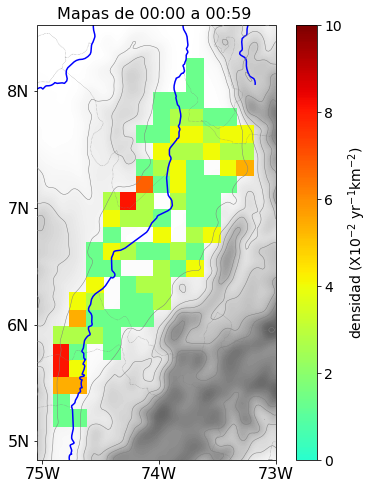

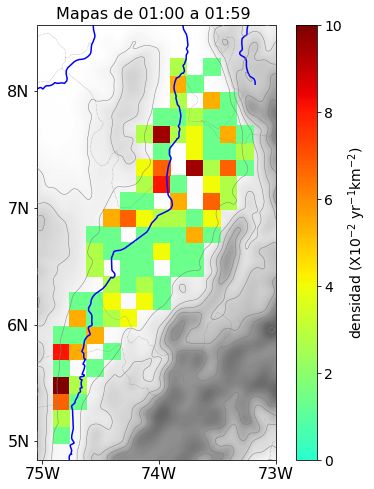

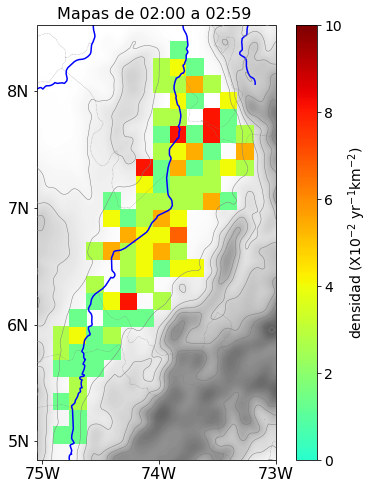

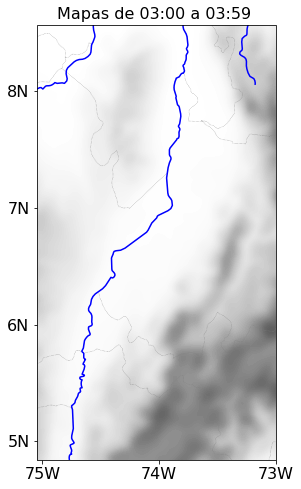

In [ ]:
for x in range(0, 24):
  print(f'Procesando hora {str(x).zfill(2)}')
  hora = str(x).zfill(2)
  dfTempSegmentado = dfTemp.loc[dfTemp['hora'] == hora].reset_index(drop=True)

 #***********************************
  # Configura el mapa
  fig = plt.figure(figsize=(7,8))
  ax1 = plt.axes(projection=ccrs.Mercator(central_longitude=-75))
  ax1.set_title(f'Mapas de {hora}:00 a {hora}:59 ',fontsize=16)
  extent = [-75.05, -73.05, 4.84, 8.56]
  ax1.set_extent(extent)
  ax1.set_xticks(np.arange(-75,-72),crs=ccrs.PlateCarree()) # Configura los indicadores de longitud
  ax1.set_yticks(np.arange(5,9),crs=ccrs.PlateCarree()) # Configura los indicadores de latitud
  lon_formatter = LongitudeFormatter(number_format='.0f',degree_symbol='',dateline_direction_label=True) # Formata longitud
  lat_formatter = LatitudeFormatter(number_format='.0f',degree_symbol='') # Formata Latitud  
  ax1.xaxis.set_major_formatter(lon_formatter) # Configura Longitud
  ax1.yaxis.set_major_formatter(lat_formatter) # Configura Latitud
  ax1.tick_params(labelsize=16)

  #***********************************
  # Ríos, fronteras, etc:

  rios = cfeature.NaturalEarthFeature(
        category='physical',
        name='rivers_lake_centerlines',
        scale='10m',
        facecolor='none' )
  limites_dep = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')
  limites_int = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_countries',
    scale='10m',
    facecolor='none')
  ax1.add_feature(limites_int, edgecolor='0.5',linewidth=0.5, linestyle=':') #estos dos son opcionales
  ax1.add_feature(limites_dep, edgecolor='0.5',linewidth=0.5, linestyle=':')
  ax1.add_feature(rios, edgecolor='blue', linewidth=1.5 ) # los ríos son importantes

  #***********************************
  #datos de altura:

  var2 = Dataset(PATH_DRIVE + PATH_DADOS + FILE_RELIEVE, mode='r')
  xtopo=np.arange(var2.variables['x_range'][0],var2.variables['x_range'][1]+0.5*var2.variables['spacing'][0],var2.variables['spacing'][0])
  ytopo=np.arange(var2.variables['y_range'][0],var2.variables['y_range'][1]+0.5*var2.variables['spacing'][1],var2.variables['spacing'][1])
  z=var2.variables['z'][:]
  var2.close()
  xt0,yt0=np.meshgrid(xtopo,ytopo)
  z=np.reshape(z,xt0.shape)[::-1,:]
  # suavizar los datos de altura:
  z=gaussian_filter(z,2)
  # niveles de elevación en escala de grises
  plt.contourf(xt0,yt0,z, cmap='Greys', levels=np.arange(0,5100,50), zorder=0, transform=ccrs.PlateCarree(),alpha=1)
  # líneas de contorno de elevación
  plt.contour(xt0,yt0,z,levels=np.arange(0,5100,500),colors='gray',linewidths=[0.5],zorder=10,transform=ccrs.PlateCarree())

  #***********************************
  # Estima o histograma 2D de los campos
  count, x_coord, y_coord = np.histogram2d(np.array(dfTempSegmentado['lon_t'], dtype=float), 
                                    np.array(dfTempSegmentado['lat_t'], dtype=float), bins = [14, 26], range= [[-75.05,-73.05],[4.84,8.56]])
  
  area = 15.93*15.91
  count = count/(area*(7/24)) #Poner en densidad == eventos/ km cuadrados * años
  
  #***********************************
  # Una escala de colores especial (opcional):
  cmap = plt.get_cmap('jet')
  jet2 = truncate_colormap(cmap, 0.4, 1)

  #***********************************
  # Inserta el histograma en el Mapa
  count.T[np.where(count.T==0)]=np.nan # para que no grafique los ceros
  im = ax1.pcolormesh( x_coord, y_coord, count.T*100, vmin = 0, vmax = 10, cmap = jet2, transform=ccrs.PlateCarree() )
  cb=plt.colorbar(im, ax = ax1)
  cb.ax.tick_params(labelsize=14)
  cb.set_label('densidad (X10$^{-2}$ yr$^{-1}$km$^{-2}$)', size=14)

  # plt.show()

  plt.savefig(PATH_DRIVE + PATH_FIGURE + f'Mapa_eventos_Temp_{hora}.png', format='png', bbox_inches = 'tight' )


# **Mapas cada 3 horas**

In [ ]:
tamano_int_horas = 3
for x in range(0, 24, tamano_int_horas):
  a = list(range(x, x + tamano_int_horas))
  a = [str(r).zfill(2) for r in a]
  print(f'Procesando hora {str(a[0])}:00 a {str(a[-1])}:59')
  dfTempSegmentado = dfTemp.loc[dfTemp['hora'].isin(a)].reset_index(drop=True)
  print(f'Tamaño : {len(dfTempSegmentado)}')

 #***********************************
  # Configura el mapa
  fig = plt.figure(figsize=(7,8))
  ax1 = plt.axes(projection=ccrs.Mercator(central_longitude=-75))
  ax1.set_title(f'Mapa de {str(a[0])}:00 a {str(a[-1])}:59',fontsize=16)
  extent = [-75.5, -72.5, 4.5, 8.5]
  ax1.set_extent(extent)
  ax1.set_xticks(np.arange(-75,-72),crs=ccrs.PlateCarree()) # Configura los indicadores de longitud
  ax1.set_yticks(np.arange(5,9),crs=ccrs.PlateCarree()) # Configura los indicadores de latitud
  lon_formatter = LongitudeFormatter(number_format='.0f',degree_symbol='',dateline_direction_label=True) # Formata longitud
  lat_formatter = LatitudeFormatter(number_format='.0f',degree_symbol='') # Formata Latitud  
  ax1.xaxis.set_major_formatter(lon_formatter) # Configura Longitud
  ax1.yaxis.set_major_formatter(lat_formatter) # Configura Latitud
  ax1.tick_params(labelsize=16)

  #***********************************
  # Ríos, fronteras, etc:

  rios = cfeature.NaturalEarthFeature(
        category='physical',
        name='rivers_lake_centerlines',
        scale='10m',
        facecolor='none' )
  limites_dep = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')
  limites_int = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_countries',
    scale='10m',
    facecolor='none')
  ax1.add_feature(limites_int, edgecolor='0.5',linewidth=0.5, linestyle=':') #estos dos son opcionales
  ax1.add_feature(limites_dep, edgecolor='0.5',linewidth=0.5, linestyle=':')
  ax1.add_feature(rios, edgecolor='blue', linewidth=1.5 ) # los ríos son importantes

  #***********************************
  #datos de altura:

  var2 = Dataset(PATH_DRIVE + PATH_DADOS + FILE_RELIEVE, mode='r')
  xtopo=np.arange(var2.variables['x_range'][0],var2.variables['x_range'][1]+0.5*var2.variables['spacing'][0],var2.variables['spacing'][0])
  ytopo=np.arange(var2.variables['y_range'][0],var2.variables['y_range'][1]+0.5*var2.variables['spacing'][1],var2.variables['spacing'][1])
  z=var2.variables['z'][:]
  var2.close()
  xt0,yt0=np.meshgrid(xtopo,ytopo)
  z=np.reshape(z,xt0.shape)[::-1,:]
  # suavizar los datos de altura:
  z=gaussian_filter(z,2)
  # niveles de elevación en escala de grises
  plt.contourf(xt0,yt0,z, cmap='Greys', levels=np.arange(0,5100,50), zorder=0, transform=ccrs.PlateCarree(),alpha=1)
  # líneas de contorno de elevación
  plt.contour(xt0,yt0,z,levels=np.arange(0,5100,500),colors='gray',linewidths=[0.5],zorder=10,transform=ccrs.PlateCarree())

  #***********************************
  # Estima o histograma 2D de los campos
  count, x_coord, y_coord = np.histogram2d(np.array(dfTempSegmentado['lon_t'], dtype=float), 
                                    np.array(dfTempSegmentado['lat_t'], dtype=float), bins = [14, 26], range= [[-75.05,-73.05],[4.84,8.56]])
  
  area = 15.93*15.91
  count = count/((area*7*tamano_int_horas)/24) #Poner en densidad == eventos/ km cuadrados * años)
  
  
  #***********************************
  # Una escala de colores especial (opcional):
  cmap = plt.get_cmap('jet')
  jet2 = truncate_colormap(cmap, 0.4, 1)

  #***********************************
  # Inserta el histograma en el Mapa
  count.T[np.where(count.T==0)]=np.nan # para que no grafique los ceros
  im = ax1.pcolormesh( x_coord, y_coord, count.T*100, vmin = 0, vmax = 10, cmap = jet2, transform=ccrs.PlateCarree() )
  cb=plt.colorbar(im, ax = ax1)
  cb.ax.tick_params(labelsize=14)
  cb.set_label('densidad (X10$^{-2}$ yr$^{-1}$km$^{-2}$)', size=14)

  # plt.show()

  plt.savefig(PATH_DRIVE + PATH_FIGURE + f'Mapa_eventos_Temp_cada 3 horas_de_{str(a[0])}:00_a_{str(a[-1])}:59.png', format='png', bbox_inches = 'tight' )

#**Mapa cada 6 horas**

In [ ]:
tamano_int_horas = 6
for x in range(0, 24, tamano_int_horas):
  a = list(range(x, x + tamano_int_horas))
  a = [str(r).zfill(2) for r in a]
  print(f'Procesando hora {str(a[0])}:00 a {str(a[-1])}:59')
  dfTempSegmentado = dfTemp.loc[dfTemp['hora'].isin(a)].reset_index(drop=True)
  print(f'Tamaño : {len(dfTempSegmentado)}')

 #***********************************
  # Configura el mapa
  fig = plt.figure(figsize=(7,8))
  ax1 = plt.axes(projection=ccrs.Mercator(central_longitude=-75))
  ax1.set_title(f'Mapa de {str(a[0])}:00 a {str(a[-1])}:59',fontsize=16)
  extent = [-75.5, -72.5, 4.5, 8.5]
  ax1.set_extent(extent)
  ax1.set_xticks(np.arange(-75,-72),crs=ccrs.PlateCarree()) # Configura los indicadores de longitud
  ax1.set_yticks(np.arange(5,9),crs=ccrs.PlateCarree()) # Configura los indicadores de latitud
  lon_formatter = LongitudeFormatter(number_format='.0f',degree_symbol='',dateline_direction_label=True) # Formata longitud
  lat_formatter = LatitudeFormatter(number_format='.0f',degree_symbol='') # Formata Latitud  
  ax1.xaxis.set_major_formatter(lon_formatter) # Configura Longitud
  ax1.yaxis.set_major_formatter(lat_formatter) # Configura Latitud
  ax1.tick_params(labelsize=16)

  #***********************************
  # Ríos, fronteras, etc:

  rios = cfeature.NaturalEarthFeature(
        category='physical',
        name='rivers_lake_centerlines',
        scale='10m',
        facecolor='none' )
  limites_dep = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')
  limites_int = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_countries',
    scale='10m',
    facecolor='none')
  ax1.add_feature(limites_int, edgecolor='0.5',linewidth=0.5, linestyle=':') #estos dos son opcionales
  ax1.add_feature(limites_dep, edgecolor='0.5',linewidth=0.5, linestyle=':')
  ax1.add_feature(rios, edgecolor='blue', linewidth=1.5 ) # los ríos son importantes

  #***********************************
  #datos de altura:

  var2 = Dataset(PATH_DRIVE + PATH_DADOS + FILE_RELIEVE, mode='r')
  xtopo=np.arange(var2.variables['x_range'][0],var2.variables['x_range'][1]+0.5*var2.variables['spacing'][0],var2.variables['spacing'][0])
  ytopo=np.arange(var2.variables['y_range'][0],var2.variables['y_range'][1]+0.5*var2.variables['spacing'][1],var2.variables['spacing'][1])
  z=var2.variables['z'][:]
  var2.close()
  xt0,yt0=np.meshgrid(xtopo,ytopo)
  z=np.reshape(z,xt0.shape)[::-1,:]
  # suavizar los datos de altura:
  z=gaussian_filter(z,2)
  # niveles de elevación en escala de grises
  plt.contourf(xt0,yt0,z, cmap='Greys', levels=np.arange(0,5100,50), zorder=0, transform=ccrs.PlateCarree(),alpha=1)
  # líneas de contorno de elevación
  plt.contour(xt0,yt0,z,levels=np.arange(0,5100,500),colors='gray',linewidths=[0.5],zorder=10,transform=ccrs.PlateCarree())

  #***********************************
  # Estima o histograma 2D de los campos
  count, x_coord, y_coord = np.histogram2d(np.array(dfTempSegmentado['lon_t'], dtype=float), 
                                    np.array(dfTempSegmentado['lat_t'], dtype=float), bins = [14, 26], range= [[-75.05,-73.05],[4.84,8.56]])
  
  area = 15.93*15.91
  count = count/((area*7*tamano_int_horas)/24) #Poner en densidad == eventos/ km cuadrados * años))
 
    
  #***********************************
  # Una escala de colores especial (opcional):
  cmap = plt.get_cmap('jet')
  jet2 = truncate_colormap(cmap, 0.4, 1)

  #***********************************
  # Inserta el histograma en el Mapa
  count.T[np.where(count.T==0)]=np.nan # para que no grafique los ceros
  im = ax1.pcolormesh( x_coord, y_coord, count.T*100, vmin = 0, vmax = 10, cmap = jet2, transform=ccrs.PlateCarree() )
  cb=plt.colorbar(im, ax = ax1)
  cb.ax.tick_params(labelsize=14)
  cb.set_label('densidad (X10$^{-2}$ yr$^{-1}$km$^{-2}$)', size=14)

  # plt.show()

  plt.savefig(PATH_DRIVE + PATH_FIGURE + f'Mapa_eventos_Temp_cada 6 horas_de_{str(a[0])}:00_a_{str(a[-1])}:59.png', format='png', bbox_inches = 'tight' )

# **Calculo de eventos nocturnos (20h hasta 07h)**

In [10]:
df_nocturno = dfTemp.loc[(dfTemp['hora'] >= '20') | (dfTemp['hora'] < '07')]

In [11]:
estaciones = {
    # 'chucuri' : {'lat' : 6.8233, 'lon' : -73.4720},
              # 'vizcaina' : {'lat' : 6.9999, 'lon' : -73.7048}, 
              'vizcaina' : {'lat' : 6.9829, 'lon' : -73.7048},
              'palanquero' : {'lat' : 5.4928, 'lon' : -74.658}
              }

gps = {'pql_gps' : {'lat' : 5.4674, 'lon' : -74.657}}

In [12]:
#***********************************
# Estima el histograma 2D de los campos  
count, x_coord, y_coord = np.histogram2d(np.array(df_nocturno['lon_t'], dtype=float),
                                          np.array(df_nocturno['lat_t'], dtype=float), bins = [14, 26], range= [[-75.05,-73.05],[4.84,8.56]])

area = 15.93*15.91
count = count/(area*7*10/24) #Poner en densidad == eventos/ km cuadrados * años

# **Mapa con eventos nocturnos (20h hasta 06h)**

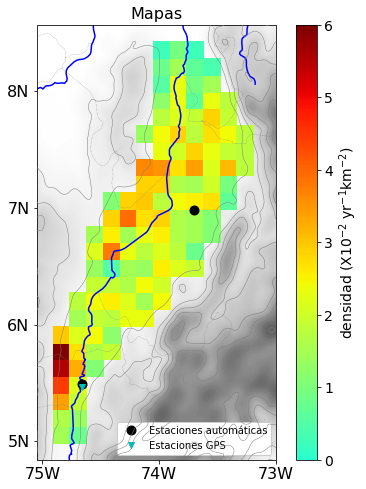

In [13]:
#***********************************
# Configura el mapa
fig = plt.figure(figsize=(7,8))
ax1 = plt.axes(projection=ccrs.Mercator(central_longitude=-75))
ax1.set_title('Mapas',fontsize=16)
extent = [-75.05, -73.05, 4.84, 8.56]
ax1.set_extent(extent)
ax1.set_xticks(np.arange(-75,-72),crs=ccrs.PlateCarree()) # Configura los indicadores de longitud
ax1.set_yticks(np.arange(5,9),crs=ccrs.PlateCarree()) # Configura los indicadores de latitud
lon_formatter = LongitudeFormatter(number_format='.0f',degree_symbol='',dateline_direction_label=True) # Formata longitud
lat_formatter = LatitudeFormatter(number_format='.0f',degree_symbol='') # Formata Latitud  
ax1.xaxis.set_major_formatter(lon_formatter) # Configura Longitud
ax1.yaxis.set_major_formatter(lat_formatter) # Configura Latitud
ax1.tick_params(labelsize=16)

#***********************************
# Ríos, fronteras, etc:

rios = cfeature.NaturalEarthFeature(
       category='physical',
       name='rivers_lake_centerlines',
       scale='10m',
       facecolor='none' )
limites_dep = cfeature.NaturalEarthFeature(
   category='cultural',
   name='admin_1_states_provinces_lines',
   scale='10m',
   facecolor='none')
limites_int = cfeature.NaturalEarthFeature(
   category='cultural',
   name='admin_0_countries',
   scale='10m',
   facecolor='none')
ax1.add_feature(limites_int, edgecolor='0.5',linewidth=0.5, linestyle=':') #estos dos son opcionales
ax1.add_feature(limites_dep, edgecolor='0.5',linewidth=0.5, linestyle=':')
ax1.add_feature(rios, edgecolor='blue', linewidth=1.5 ) # los ríos son importantes

#***********************************
#datos de altura:

var2 = Dataset(PATH_DRIVE + PATH_DADOS + FILE_RELIEVE, mode='r')
xtopo=np.arange(var2.variables['x_range'][0],var2.variables['x_range'][1]+0.5*var2.variables['spacing'][0],var2.variables['spacing'][0])
ytopo=np.arange(var2.variables['y_range'][0],var2.variables['y_range'][1]+0.5*var2.variables['spacing'][1],var2.variables['spacing'][1])
z=var2.variables['z'][:]
var2.close()
xt0,yt0=np.meshgrid(xtopo,ytopo)
z=np.reshape(z,xt0.shape)[::-1,:]
# suavizar los datos de altura:
z=gaussian_filter(z,2)
# niveles de elevación en escala de grises
plt.contourf(xt0,yt0,z, cmap='Greys', levels=np.arange(0,5100,50), zorder=0, transform=ccrs.PlateCarree(),alpha=1)
# líneas de contorno de elevación
plt.contour(xt0,yt0,z,levels=np.arange(0,5100,500),colors='gray',linewidths=[0.5],zorder=10,transform=ccrs.PlateCarree())

#***********************************
# Una escala de colores especial (opcional):
cmap = plt.get_cmap('jet')
jet2 = truncate_colormap(cmap, 0.4, 1)

#***********************************
# Inserta el histograma en el Mapa
count.T[np.where(count.T==0)]=np.nan # para que no grafique los ceros
im = ax1.pcolormesh( x_coord, y_coord, count.T*100, vmin = 0, vmax = 6, cmap = jet2, transform=ccrs.PlateCarree() )
cb=plt.colorbar(im, ax = ax1)
cb.ax.tick_params(labelsize=14)
cb.set_label('densidad (X10$^{-2}$ yr$^{-1}$km$^{-2}$)', size=14)

#***********************************
# coloca la posición de las estaciones
lat_est = []
lon_est = []
for est in estaciones:
  lat_est.append(estaciones[est]['lat'])
  lon_est.append(estaciones[est]['lon'])
ax1.plot(lon_est, lat_est, 'ko', markersize=9, transform=ccrs.PlateCarree(), label = 'Estaciones automáticas') 

#***********************************
# coloca la posición de las estaciones GPS
lat_gps = []
lon_gps = []
for est in gps:
  lat_gps.append(gps[est]['lat'])
  lon_gps.append(gps[est]['lon'])
ax1.plot(lon_gps, lat_gps, 'cv', markersize=6, transform=ccrs.PlateCarree(), label = 'Estaciones GPS') 

legend = ax1.legend(loc='lower right', framealpha = 1.0)
legend.get_frame().set_facecolor('white')

# plt.show()
plt.savefig(PATH_DRIVE + PATH_FIGURE + 'Mapa_eventos_Temp_Nocturno_20h_a_07h.png', format='png', bbox_inches = 'tight' )

#**Análisis de eventos**

In [14]:
def list_average(list_coord, window_size):

  i = 0
  moving_averages = []
  while i < len(list_coord) - window_size + 1:
    this_window = list_coord[i : i + window_size]
    window_average = sum(this_window) / window_size
    moving_averages.append(window_average)
    i += 1
  return moving_averages

In [22]:
# Configuración de parámetros

estacion = 'palanquero'
coordenadas_estacion = np.array([estaciones[estacion]['lon'], estaciones[estacion]['lat']])

In [23]:
# Estimando punto medio de cada cuadro
x_media_coord = list_average(x_coord, 2)
y_media_coord = list_average(y_coord, 2)

# Creando matriz con los valores de los puntos medios de la malla de eventos del histograma
a = np.array([[i, j] for i in x_media_coord 
                 for j in y_media_coord])
b = np.reshape(a, (14, 26, 2))

# Encontrando el cuadro con la estación usando la heurística de la distancia
distancia = np.linalg.norm(b - coordenadas_estacion, axis=2)
pos_dist = np.where(distancia == np.min(distancia))
if estacion == 'palanquero':
  list_pos = [[pos_dist[0][0], pos_dist[1][0]], 
            [pos_dist[0][0], pos_dist[1][0] - 1], 
            [pos_dist[0][0], pos_dist[1][0]+1],
            [pos_dist[0][0] - 1, pos_dist[1][0]], 
            [pos_dist[0][0] - 1, pos_dist[1][0] - 1], 
            [pos_dist[0][0] - 1, pos_dist[1][0]+1]]
elif estacion == 'vizcaina':
  list_pos = [[pos_dist[0][0], pos_dist[1][0]], 
            [pos_dist[0][0], pos_dist[1][0]+1],
            [pos_dist[0][0] + 1, pos_dist[1][0] + 1],
            [pos_dist[0][0] - 1, pos_dist[1][0] + 1],
            [pos_dist[0][0] + 1, pos_dist[1][0]],
            [pos_dist[0][0] - 1, pos_dist[1][0]], 
            ]

list_pos

[[2, 4], [2, 3], [2, 5], [1, 4], [1, 3], [1, 5]]

In [24]:
# Conociendo el cuadro que engloba la estación, encontramos los eventos que componen ese cuadro
# pd.set_option('display.max_rows', None)
list_df = []
n_acu = 0 

for pos in list_pos:
  pos_cuadro_pal = b[pos[0], pos[1]]
  func_dist = lambda df : ((df[0] - df[1])**2 + (df[2] - df[3])**2)**(1/2)
  dfaux_nocturno = df_nocturno.copy()
  dfaux_nocturno['lon_t_palanquero'] = pos_cuadro_pal[0]
  dfaux_nocturno['lat_t_palanquero'] = pos_cuadro_pal[1]
  dfaux_nocturno['distancia'] = dfaux_nocturno[['lon_t', 'lon_t_palanquero', 'lat_t', 'lat_t_palanquero']].apply(func_dist, axis=1)

  # Ordenar los datos, encontrar el número de eventos asociado a ese cuadro, seleccionarlos y guardarlos
  dfaux_nocturno = dfaux_nocturno.sort_values(by=['distancia']).reset_index(drop = True)
  n = count[pos[0], pos[1]]*(area*7*10/24)
  print(f'Número de eventos en grilla {pos_cuadro_pal} ---> {n}')
  n_acu += n 
  dfaux_eventos = dfaux_nocturno.loc[:n-1]
  list_df.append(dfaux_eventos)

print(f"Total de eventos : {int(n_acu)}")

dfselect = pd.concat(list_df)
dfselect.to_csv(PATH_DRIVE + PATH_DADOS + f'eventos_{estacion}_2.csv', header=True, index=False, sep = ';')

Número de eventos en grilla [-74.69285714   5.48384615] ---> 16.0
Número de eventos en grilla [-74.69285714   5.34076923] ---> 14.0
Número de eventos en grilla [-74.69285714   5.62692308] ---> 24.0
Número de eventos en grilla [-74.83571429   5.48384615] ---> 33.0
Número de eventos en grilla [-74.83571429   5.34076923] ---> 25.000000000000004
Número de eventos en grilla [-74.83571429   5.62692308] ---> 41.0
Total de eventos : 153


In [ ]:
### Coger los 16 eventos (cuadro de la estación) y ver en que horario aparecen
# count[1:4, 3:7]*(area*7*10/24)

# **Mapa con eventos diurnos (12h hasta 20h)**


In [ ]:
df_diurno = dfTemp.loc[(dfTemp['hora'] >= '12') & (dfTemp['hora'] < '20')]

In [ ]:
#***********************************
# Estima el histograma 2D de los campos  
count, x_coord, y_coord = np.histogram2d(np.array(df_diurno['lon_t'], dtype=float),
                                          np.array(df_diurno['lat_t'], dtype=float), bins = [14, 26], range= [[-75.05,-73.05],[4.84,8.56]])

area = 15.93*15.91
count = count/(area*7*8/24) #Poner en densidad == eventos/ km cuadrados * años

In [ ]:
#***********************************
# Configura el mapa
fig = plt.figure(figsize=(7,8))
ax1 = plt.axes(projection=ccrs.Mercator(central_longitude=-75))
ax1.set_title('Mapas',fontsize=16)
extent = [-75.05, -73.05, 4.84, 8.56]
ax1.set_extent(extent)
ax1.set_xticks(np.arange(-75,-72),crs=ccrs.PlateCarree()) # Configura los indicadores de longitud
ax1.set_yticks(np.arange(5,9),crs=ccrs.PlateCarree()) # Configura los indicadores de latitud
lon_formatter = LongitudeFormatter(number_format='.0f',degree_symbol='',dateline_direction_label=True) # Formata longitud
lat_formatter = LatitudeFormatter(number_format='.0f',degree_symbol='') # Formata Latitud  
ax1.xaxis.set_major_formatter(lon_formatter) # Configura Longitud
ax1.yaxis.set_major_formatter(lat_formatter) # Configura Latitud
ax1.tick_params(labelsize=16)

#***********************************
# Ríos, fronteras, etc:

rios = cfeature.NaturalEarthFeature(
       category='physical',
       name='rivers_lake_centerlines',
       scale='10m',
       facecolor='none' )
limites_dep = cfeature.NaturalEarthFeature(
   category='cultural',
   name='admin_1_states_provinces_lines',
   scale='10m',
   facecolor='none')
limites_int = cfeature.NaturalEarthFeature(
   category='cultural',
   name='admin_0_countries',
   scale='10m',
   facecolor='none')
ax1.add_feature(limites_int, edgecolor='0.5',linewidth=0.5, linestyle=':') #estos dos son opcionales
ax1.add_feature(limites_dep, edgecolor='0.5',linewidth=0.5, linestyle=':')
ax1.add_feature(rios, edgecolor='blue', linewidth=1.5 ) # los ríos son importantes

#***********************************
#datos de altura:

var2 = Dataset(PATH_DRIVE + PATH_DADOS + FILE_RELIEVE, mode='r')
xtopo=np.arange(var2.variables['x_range'][0],var2.variables['x_range'][1]+0.5*var2.variables['spacing'][0],var2.variables['spacing'][0])
ytopo=np.arange(var2.variables['y_range'][0],var2.variables['y_range'][1]+0.5*var2.variables['spacing'][1],var2.variables['spacing'][1])
z=var2.variables['z'][:]
var2.close()
xt0,yt0=np.meshgrid(xtopo,ytopo)
z=np.reshape(z,xt0.shape)[::-1,:]
# suavizar los datos de altura:
z=gaussian_filter(z,2)
# niveles de elevación en escala de grises
plt.contourf(xt0,yt0,z, cmap='Greys', levels=np.arange(0,5100,50), zorder=0, transform=ccrs.PlateCarree(),alpha=1)
# líneas de contorno de elevación
plt.contour(xt0,yt0,z,levels=np.arange(0,5100,500),colors='gray',linewidths=[0.5],zorder=10,transform=ccrs.PlateCarree())

#***********************************
# Una escala de colores especial (opcional):
cmap = plt.get_cmap('jet')
jet2 = truncate_colormap(cmap, 0.4, 1)

#***********************************
# Inserta el histograma en el Mapa
count.T[np.where(count.T==0)]=np.nan # para que no grafique los ceros
im = ax1.pcolormesh( x_coord, y_coord, count.T*100, vmin = 0, vmax = 6, cmap = jet2, transform=ccrs.PlateCarree() )
cb=plt.colorbar(im, ax = ax1)
cb.ax.tick_params(labelsize=14)
cb.set_label('densidad (X10$^{-2}$ yr$^{-1}$km$^{-2}$)', size=14)

#***********************************
# coloca la posición de las estaciones
lat_est = []
lon_est = []
for est in estaciones:
  lat_est.append(estaciones[est]['lat'])
  lon_est.append(estaciones[est]['lon'])
ax1.plot(lon_est, lat_est, 'ko', markersize=9, transform=ccrs.PlateCarree(), label = 'Estaciones automáticas') 

#***********************************
# coloca la posición de las estaciones GPS
lat_gps = []
lon_gps = []
for est in gps:
  lat_gps.append(gps[est]['lat'])
  lon_gps.append(gps[est]['lon'])
ax1.plot(lon_gps, lat_gps, 'gv', markersize=6, transform=ccrs.PlateCarree(), label = 'Estaciones GPS') 

legend = ax1.legend(loc='lower right', framealpha = 1.0)
legend.get_frame().set_facecolor('white')

# plt.show()
plt.savefig(PATH_DRIVE + PATH_FIGURE + 'Mapa_eventos_Temp_Diurno_12h_a_20h.png', format='png', bbox_inches = 'tight' )

In [ ]:
np.nanmax(count)*100




# Mapa hora...  falta Terminar



In [ ]:
#######################
## Subplot pendiente... 
#######################
rows = 1
columns = 2
fig, axs = plt.subplots(rows, columns, subplot_kw = dict(projection=ccrs.Mercator(central_longitude=-75)), figsize=(7,8))
for i in range(0, rows):
  for j in range(0, columns):
    hora = str(columns * i + j).zfill(2)
    print(f'Procesando hora {hora}')
    hora_int = int(hora)
    dfTempSegmentado = dfTemp.loc[dfTemp['hora'] == hora].reset_index(drop=True)

  #***********************************
    # Configura el mapa
    # fig = plt.figure(figsize=(7,8))
    axs[hora_int].set_title(f'Mapa Hora {hora}:00 - {hora}:59',fontsize=16)
    extent = [-75.5, -72.5, 4.5, 8.5]
    axs[hora_int].set_extent(extent)
    axs[hora_int].set_xticks(np.arange(-75,-72),crs=ccrs.PlateCarree()) # Configura los indicadores de longitud
    axs[hora_int].set_yticks(np.arange(5,9),crs=ccrs.PlateCarree()) # Configura los indicadores de latitud
    lon_formatter = LongitudeFormatter(number_format='.0f',degree_symbol='',dateline_direction_label=True) # Formata longitud
    lat_formatter = LatitudeFormatter(number_format='.0f',degree_symbol='') # Formata Latitud  
    axs[hora_int].xaxis.set_major_formatter(lon_formatter) # Configura Longitud
    axs[hora_int].yaxis.set_major_formatter(lat_formatter) # Configura Latitud
    axs[hora_int].tick_params(labelsize=16)

    #***********************************
    # Ríos, fronteras, etc:

    rios = cfeature.NaturalEarthFeature(
          category='physical',
          name='rivers_lake_centerlines',
          scale='10m',
          facecolor='none' )
    limites_dep = cfeature.NaturalEarthFeature(
      category='cultural',
      name='admin_1_states_provinces_lines',
      scale='10m',
      facecolor='none')
    limites_int = cfeature.NaturalEarthFeature(
      category='cultural',
      name='admin_0_countries',
      scale='10m',
      facecolor='none')
    axs[hora_int].add_feature(limites_int, edgecolor='0.5',linewidth=0.5, linestyle=':') #estos dos son opcionales
    axs[hora_int].add_feature(limites_dep, edgecolor='0.5',linewidth=0.5, linestyle=':')
    axs[hora_int].add_feature(rios, edgecolor='blue', linewidth=1.5 ) # los ríos son importantes

    #***********************************
    #datos de altura:

    var2 = Dataset(PATH_DRIVE + PATH_DADOS + FILE_RELIEVE, mode='r')
    xtopo=np.arange(var2.variables['x_range'][0],var2.variables['x_range'][1]+0.5*var2.variables['spacing'][0],var2.variables['spacing'][0])
    ytopo=np.arange(var2.variables['y_range'][0],var2.variables['y_range'][1]+0.5*var2.variables['spacing'][1],var2.variables['spacing'][1])
    z=var2.variables['z'][:]
    var2.close()
    xt0,yt0=np.meshgrid(xtopo,ytopo)
    z=np.reshape(z,xt0.shape)[::-1,:]
    # suavizar los datos de altura:
    z=gaussian_filter(z,2)
    # niveles de elevación en escala de grises
    axs[hora_int].contourf(xt0,yt0,z, cmap='Greys', levels=np.arange(0,5100,50), zorder=0, transform=ccrs.PlateCarree(),alpha=1)
    # líneas de contorno de elevación
    axs[hora_int].contour(xt0,yt0,z,levels=np.arange(0,5100,500),colors='gray',linewidths=[0.5],zorder=10,transform=ccrs.PlateCarree())

    #***********************************
    # Estima o histograma 2D de los campos
    count, x_coord, y_coord = np.histogram2d(np.array(dfTempSegmentado['lon_t'], dtype=float), 
                                      np.array(dfTempSegmentado['lat_t'], dtype=float), bins = [10, 20])
    
    max_count = np.amax(count)
    # count = count/max_count
    
    #***********************************
    # Una escala de colores especial (opcional):
    cmap = plt.get_cmap('jet')
    jet2 = truncate_colormap(cmap, 0.4, 1)

    #***********************************
    # Inserta el histograma en el Mapa
    count.T[np.where(count.T==0)]=np.nan # para que no grafique los ceros
    im = axs[hora_int].pcolormesh( x_coord, y_coord, count.T, vmin = 0, vmax = max_count, cmap = jet2, transform=ccrs.PlateCarree() )
    cb=plt.colorbar(im, ax = axs[hora_int])
    cb.ax.tick_params(labelsize=14)
    cb.set_label('densidad (yr$^{-1}$km$^{-2}$)', size=14)

    # plt.show()

    # plt.savefig(PATH_DRIVE + PATH_FIGURE + f'Mapa_eventos_Temp_{hora}.png', format='png', bbox_inches = 'tight' )
